# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
# импортируем библиотеки визуализации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# импортируем алгоритмы для машинного обучения
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# импортируем модуль для выделения выборок
from sklearn.model_selection import train_test_split
# импортируем метрики качества
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Загрузка и исследование данных

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [5]:
# посчитаем корреляции
corr = df.corr()
corr

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


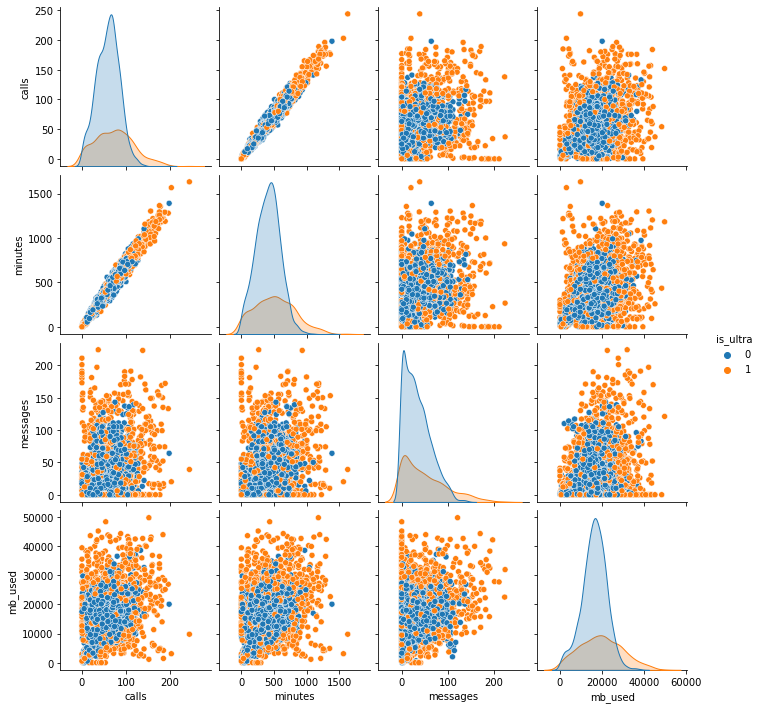

In [6]:
# построим парные графики
sns.pairplot(data=df, hue = 'is_ultra')

In [7]:
# уберём лишнюю переменную
df = df.drop(['minutes'], axis=1)

**Вывод.** Данные загрузились нормально. Пропусков или иных проблем нет.

## Разбиение данные на выборки

Радзделим данные на три выборки: обучающую, валидационную и тестовую.

In [8]:
# разделяем последовательно на три части
df_train, df_ = train_test_split(df, test_size=0.4, random_state=12345) 
df_valid, df_test = train_test_split(df_, test_size=0.5, random_state=12345)

# создаём обучающую выборку
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
# создаём валидационную выборку
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
# создаём тестовую выборку
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

Проверим результат.

In [9]:
a1 = features_train.shape[0]
a2 = features_valid.shape[0]
a3 = features_test.shape[0]
a = df.shape[0]
print('Проверим разделение.')
print('Обучающая выборка', a1, round(100 * a1 / a), '%')
print('Валидационная выборка', a2, round(100 * a2 / a), '%')
print('Тестовая выборка', a3, round(100 * a3 / a), '%')
print('Вся выборка', a1, round(100 * (a1+a2+a3) / a), '%')

Проверим разделение.
Обучающая выборка 1928 60 %
Валидационная выборка 643 20 %
Тестовая выборка 643 20 %
Вся выборка 1928 100 %


**Вывод.** Всё данные разделены правильно.

## Исследование моделей

In [10]:
# создадим словарь для сохранения самых лучших моделей в исследовании
best_models = {}

### Модель № 1. Логистическая регрессия

In [11]:
model_name = 'Модель № 1. Логистическая регрессия'
model = LogisticRegression()
model.fit(features_train, target_train) # обучите модель
predictions_valid = model.predict(features_valid) # получите предсказания модели
result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели

best_model = model
best_models[model_name] = best_model
print("Accuracy:", result)

Accuracy: 0.7076205287713841


### Модель № 2. Дерево решений -  Глубина дерева

In [12]:
model_name = 'Модель № 2. Дерево решений - Глубина дерева'
best_model = None
x = []
y = []
best_result = 0
best_depth = 0
for depth in range(1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучите модель
    predictions_valid = model.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели
    x.append(depth)
    y.append(result)
    if result > best_result:
        print("Невый лучшей результат модели:", best_result, depth)
        best_model = model
        best_result = result
        best_depth = depth

model2 = best_model
best_models[model_name] = best_model
print("Accuracy лучшей модели:", best_result, 'Максимальная глубина', best_depth)

Невый лучшей результат модели: 0 1
Невый лучшей результат модели: 0.7542768273716952 2
Невый лучшей результат модели: 0.7838258164852255 3
Невый лучшей результат модели: 0.7869362363919129 5
Accuracy лучшей модели: 0.7900466562986003 Максимальная глубина 5


Text(0, 0.5, 'Правильность (Accuracy)')

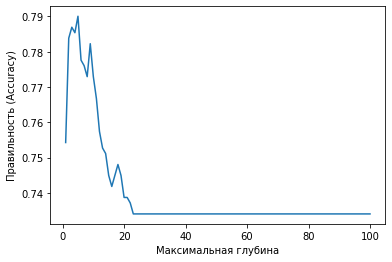

In [13]:
plt.plot(x,y)
plt.xlabel('Максимальная глубина')
plt.ylabel('Правильность (Accuracy)')

### Модель № 3. Дерево решений -  Количество объектов на листьях

Исследуем, как меняется качество модели в зависимости от `min_samples_leaf`.

In [14]:
model_name = 'Модель № 3. Дерево решений - Количество объектов на листьях'
best_model = None
x = []
y = []
best_result = 0
best_samples_leaf = 0
for samples_leaf in range(1, 101):
    model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=samples_leaf) # обучите модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучите модель
    predictions_valid = model.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели
    x.append(samples_leaf)
    y.append(result)
    if result > best_result:
        print("Невый лучшей результат модели:", best_result, samples_leaf)
        best_model = model
        best_result = result
        best_samples_leaf = samples_leaf

model3 = best_model
best_models[model_name] = best_model
print("Accuracy лучшей модели:", best_result, 'Минимум объектов в листьях:', best_samples_leaf)

Невый лучшей результат модели: 0 1
Невый лучшей результат модели: 0.7340590979782271 2
Невый лучшей результат модели: 0.7511664074650077 4
Невый лучшей результат модели: 0.7527216174183515 6
Невый лучшей результат модели: 0.7620528771384136 7
Невый лучшей результат модели: 0.7651632970451011 9
Невый лучшей результат модели: 0.7698289269051322 13
Невый лучшей результат модели: 0.7729393468118196 22
Невый лучшей результат модели: 0.7776049766718507 23
Невый лучшей результат модели: 0.7853810264385692 34
Accuracy лучшей модели: 0.7884914463452566 Минимум объектов в листьях: 34


Text(0, 0.5, 'Правильность (Accuracy)')

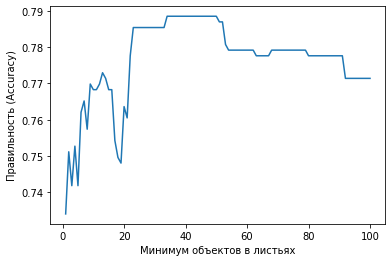

In [15]:
plt.plot(x,y)
plt.xlabel('Минимум объектов в листьях')
plt.ylabel('Правильность (Accuracy)')

Самая большая правильность при `min_samples_leaf` равном 37, хотя и 2, 6, 7 и 10 тоже неплохие.

### Модель № 4. Дерево решений -  Максимум узлов

Исследуем, как изменение `max_leaf_nodes` влияет на качество модели.

In [16]:
model_name = 'Модель № 4. Дерево решений - Максимум узлов'
best_model = None
x = []
y = []
best_result = 0
best_nodes = 0
for nodes in range(3, 101):
    model = DecisionTreeClassifier(random_state=12345, max_leaf_nodes=nodes) # обучите модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучите модель
    predictions_valid = model.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели
    x.append(nodes)
    y.append(result)
    if result > best_result:
        print("Невый лучшей результат модели:", best_result, nodes)
        best_model = model
        best_result = result
        best_nodes = nodes

model4 = best_model
best_models[model_name] = best_model
print("Accuracy лучшей модели:", best_result, 'Максимум узлов:', best_nodes)

Невый лучшей результат модели: 0 3
Невый лучшей результат модели: 0.7838258164852255 4
Невый лучшей результат модели: 0.7869362363919129 6
Невый лучшей результат модели: 0.7884914463452566 8
Accuracy лучшей модели: 0.7900466562986003 Максимум узлов: 8


Text(0, 0.5, 'Правильность (Accuracy)')

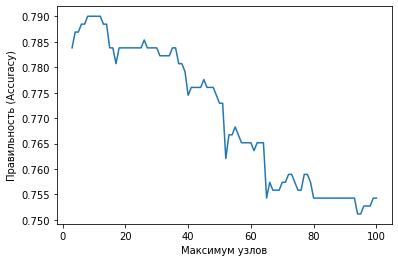

In [17]:
plt.plot(x,y)
plt.xlabel('Максимум узлов')
plt.ylabel('Правильность (Accuracy)')

Наилучшее количество узлов - 8.

### Модель № 5.  Идеальное дерево

Исследуем, каким будет качество у модели дерева решений, сочетающего все наилучшие параметры:
- `min_samples_leaf` = 37
- `max_depth` = 3
- `max_leaf_nodes`= 8

In [18]:
model_name = 'Модель № 5. Идеальное дерево'
model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=37, max_depth=3,max_leaf_nodes= 8) # обучите модель с заданным количеством деревьев
model.fit(features_train, target_train) # обучите модель на тренировочной выборке
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели на валидационной выборке        

best_models[model_name] = model
print("Accuracy лучшей модели:", result, 'Минимум объектов в листьях:', 2, 'Максимальная глубина:',3)

Accuracy лучшей модели: 0.7869362363919129 Минимум объектов в листьях: 2 Максимальная глубина: 3


### Модель № 6. Случайный лес - Количество деревьев

In [19]:
# отыщем область наилучших значений
model_name = 'Модель № 6. Случайный лес - Количество деревьев'
best_model = None
best_est = 0
x = []
y = []
best_result = 0
for est in range(10, 500,10):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели на валидационной выборке        
    x.append(est)
    y.append(result)
    if result > best_result:
        print("Невый лучшей результат модели:", best_result, 'Количество деревьев:', est)
        best_model = model
        best_result = result
        best_est = est

model6 = best_model
best_models[model_name] = best_model
print("Accuracy лучшей модели:", best_result, 'Количество деревьев:', best_est)

Невый лучшей результат модели: 0 Количество деревьев: 10
Невый лучшей результат модели: 0.7698289269051322 Количество деревьев: 20
Невый лучшей результат модели: 0.7807153965785381 Количество деревьев: 30
Невый лучшей результат модели: 0.7838258164852255 Количество деревьев: 40
Accuracy лучшей модели: 0.7900466562986003 Количество деревьев: 40


Ориентировочно, наилучшее значение `n_estimators` окола 40.

In [20]:
# отыщем наилучшее значение
model_name = 'Модель № 6. Случайный лес - Количество деревьев'
best_model = None
best_est = 0
x = []
y = []
best_result = 0
for est in range(2, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели на валидационной выборке        
    x.append(est)
    y.append(result)
    if result > best_result:
        print("Невый лучшей результат модели:", best_result, 'Количество деревьев:', est)
        best_model = model
        best_result = result
        best_est = est

model6 = best_model
best_models[model_name] = best_model
print("Accuracy лучшей модели:", best_result, 'Количество деревьев:', best_est)

Невый лучшей результат модели: 0 Количество деревьев: 2
Невый лучшей результат модели: 0.7682737169517885 Количество деревьев: 10
Невый лучшей результат модели: 0.7698289269051322 Количество деревьев: 12
Невый лучшей результат модели: 0.7776049766718507 Количество деревьев: 17
Невый лучшей результат модели: 0.7807153965785381 Количество деревьев: 19
Невый лучшей результат модели: 0.7869362363919129 Количество деревьев: 22
Невый лучшей результат модели: 0.7884914463452566 Количество деревьев: 40
Accuracy лучшей модели: 0.7900466562986003 Количество деревьев: 40


Text(0, 0.5, 'Правильность (Accuracy)')

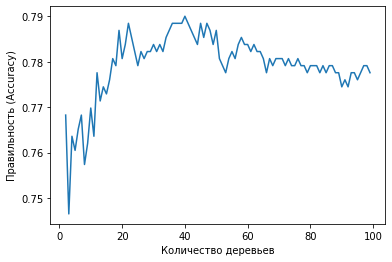

In [21]:
plt.plot(x,y)
plt.xlabel('Количество деревьев')
plt.ylabel('Правильность (Accuracy)')

Максимального значения `Accuracy` дочтигает при 23 деревьях. Это вполне оптимальный результат. Второй пик оптимальных решений при `n_estimators` около 50 деревьев, что может быть излише при меньшем качестве.

### Модель № 7. Случайный лес - Количество деревьев и глубина 3

Зафиксируем глубину дерева на 3 как самом оптимальном и посмотрим, как изменится качество.

In [22]:
model_name = 'Модель № 7. Случайный лес - Количество деревьев и глубина 3'
best_model = None
best_est = 0
x = []
y = []
best_result = 0
for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=3) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели на валидационной выборке        
    x.append(est)
    y.append(result)
    if result > best_result:
        print("Невый лучшей результат модели:", result, 'Количество деревьев:', est)
        best_model = model
        best_result = result
        best_est = est

model7 = best_model
best_models[model_name] = best_model
print("Accuracy лучшей модели:", best_result, 'Количество деревьев:', best_est)

Невый лучшей результат модели: 0.7589424572317263 Количество деревьев: 1
Невый лучшей результат модели: 0.7791601866251944 Количество деревьев: 2
Невый лучшей результат модели: 0.7838258164852255 Количество деревьев: 3
Невый лучшей результат модели: 0.7869362363919129 Количество деревьев: 11
Невый лучшей результат модели: 0.7884914463452566 Количество деревьев: 69
Невый лучшей результат модели: 0.7900466562986003 Количество деревьев: 71
Accuracy лучшей модели: 0.7900466562986003 Количество деревьев: 71


Text(0, 0.5, 'Правильность (Accuracy)')

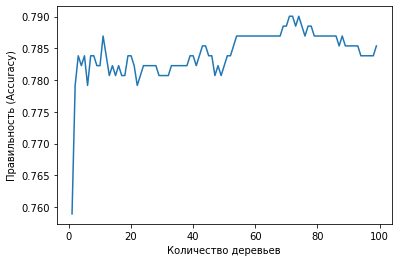

In [23]:
plt.plot(x,y)
plt.xlabel('Количество деревьев')
plt.ylabel('Правильность (Accuracy)')

Качество несколько ухудшилось.

### Модель № 8. Случайный лес - узкий подбор

Будем одновременно подбирать оптимальные значения гиперпараметров `n_estimators` (количество деревьев) и `max_depth` (максимальная глубина).

In [24]:
model_name = 'Модель № 8. Случайный лес - узкий подбор'
best_model = None
best_result = 0
best_est = 0
best_depth = 0

y = []
for depth in range (1, 6):
    x = []
    for est in range(1, 26):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # инициализируйте модель RandomForestRegressor с параметрами 
        model.fit(features_train, target_train) # обучите модель на тренировочной выборке
        predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
        result = accuracy_score(target_valid, predictions_valid) 
        x.append(result)
        
        if result > best_result:
            print("Невый лучшей результат модели:", result, 'Количество деревьев:', est, "Максимальная глубина:", depth)
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
    y.append(x)
model8 = best_model
best_models[model_name] = best_model
print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

Невый лучшей результат модели: 0.7293934681181959 Количество деревьев: 1 Максимальная глубина: 1
Невый лучшей результат модели: 0.7527216174183515 Количество деревьев: 2 Максимальная глубина: 1
Невый лучшей результат модели: 0.7542768273716952 Количество деревьев: 3 Максимальная глубина: 1
Невый лучшей результат модели: 0.76049766718507 Количество деревьев: 4 Максимальная глубина: 1
Невый лучшей результат модели: 0.7636080870917574 Количество деревьев: 9 Максимальная глубина: 1
Невый лучшей результат модели: 0.7651632970451011 Количество деревьев: 25 Максимальная глубина: 1
Невый лучшей результат модели: 0.7776049766718507 Количество деревьев: 4 Максимальная глубина: 2
Невый лучшей результат модели: 0.7822706065318819 Количество деревьев: 18 Максимальная глубина: 2
Невый лучшей результат модели: 0.7838258164852255 Количество деревьев: 19 Максимальная глубина: 2
Невый лучшей результат модели: 0.7853810264385692 Количество деревьев: 23 Максимальная глубина: 2
Невый лучшей результат модел

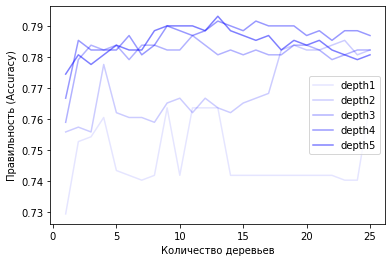

In [25]:
xx = []
for i in range(1,26):
    xx.append(i)
n = 1
for x in y:
    plt.plot(xx,x, alpha=0.1*n, c='b',label='depth'+str(n))
    n+=1
plt.xlabel('Количество деревьев')
plt.ylabel('Правильность (Accuracy)')
plt.legend()

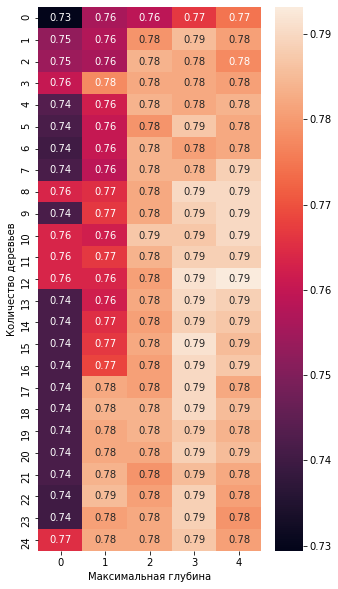

In [26]:
# визуализируем график
c = np.array(y)
c = np.transpose(c)
fig, ax = plt.subplots(figsize=(5,10))
aaa = sns.heatmap(c, annot=True, ax=ax)
plt.figsize=(1,20)
plt.xlabel('Максимальная глубина')
plt.xticks = [z for z in range(1,26)]
plt.ylabel('Количество деревьев')
plt.yticks = [z for z in range(1,6)]

### Модель № 9. Случайный лес - Широкий перебор

Расширим диапазон этих же гиперпараметров.

In [27]:
model_name = 'Модель № 9. Случайный лес - Широкий перебор'
best_model = None
best_result = 0
best_est = 0
best_depth = 0

y = []
for depth in range (1, 11):
    x = []
    for est in range(1, 101):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # инициализируйте модель RandomForestRegressor с параметрами 
        model.fit(features_train, target_train) # обучите модель на тренировочной выборке
        predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
        result = accuracy_score(target_valid, predictions_valid) 
        x.append(result)
        
        if result > best_result:
            print("Невый лучшей результат модели:", result, 'Количество деревьев:', est, "Максимальная глубина:", depth)
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
    y.append(x)
model9 = best_model
best_models[model_name] = best_model
print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

Невый лучшей результат модели: 0.7293934681181959 Количество деревьев: 1 Максимальная глубина: 1
Невый лучшей результат модели: 0.7527216174183515 Количество деревьев: 2 Максимальная глубина: 1
Невый лучшей результат модели: 0.7542768273716952 Количество деревьев: 3 Максимальная глубина: 1
Невый лучшей результат модели: 0.76049766718507 Количество деревьев: 4 Максимальная глубина: 1
Невый лучшей результат модели: 0.7636080870917574 Количество деревьев: 9 Максимальная глубина: 1
Невый лучшей результат модели: 0.7651632970451011 Количество деревьев: 25 Максимальная глубина: 1
Невый лучшей результат модели: 0.7776049766718507 Количество деревьев: 4 Максимальная глубина: 2
Невый лучшей результат модели: 0.7822706065318819 Количество деревьев: 18 Максимальная глубина: 2
Невый лучшей результат модели: 0.7838258164852255 Количество деревьев: 19 Максимальная глубина: 2
Невый лучшей результат модели: 0.7853810264385692 Количество деревьев: 23 Максимальная глубина: 2
Невый лучшей результат модел

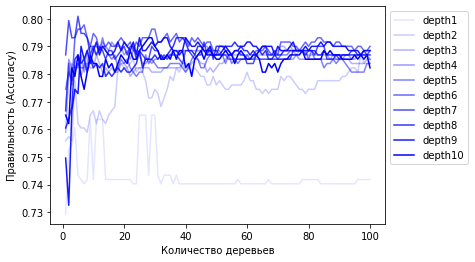

In [28]:
xx = []
for i in range(1,101):
    xx.append(i)
n = 1
for x in y:
    plt.plot(xx,x, alpha=0.1*n, c='b',label='depth'+str(n))
    n+=1
plt.xlabel('Количество деревьев')
plt.ylabel('Правильность (Accuracy)')
plt.legend(bbox_to_anchor=(1, 1.0))

Text(69.0, 0.5, 'Количество деревьев')

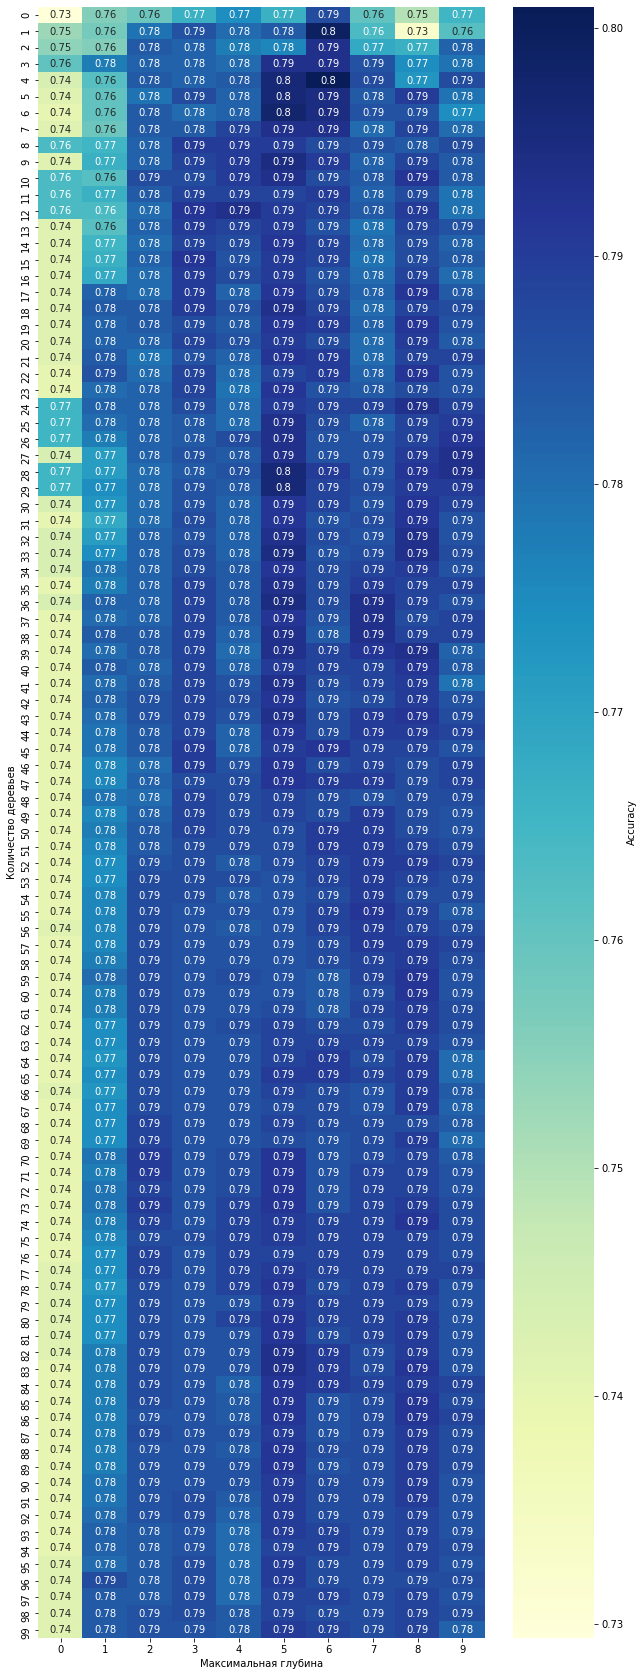

In [29]:
# визуализируем график
c = np.array(y)
c = np.transpose(c)
fig, ax = plt.subplots(figsize=(10,30))
sns.heatmap(c, annot=True, ax=ax, cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
plt.xlabel('Максимальная глубина')
plt.ylabel('Количество деревьев')
#ax.set_xticks( [z for z in range(1,11)])
#ax.set_yticks( [z for z in range(1,101)])

Чем глубже дерево, тем больше правильность. 

### Модель № 10. Идеальный случайный лес

Расширим диапазон этих же гиперпараметров.

Исследуем, склолько понадобится идеальных деревьев решений (См. выше), имеющих все наилучшие параметры:
- `min_samples_leaf` = 37
- `max_depth`=3
- `max_leaf_nodes` = 8

In [30]:
model_name = 'Модель № 10. Идеальный случайный лес'
best_model = None
best_est = 0
x = []
y = []
best_result = 0
for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=3, min_samples_leaf = 37, max_leaf_nodes= 8) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid) # посчитайте качество модели на валидационной выборке        
    x.append(est)
    y.append(result)
    if result > best_result:
        print("Невый лучшей результат модели:", best_result, 'Количество деревьев:', est)
        best_model = model
        best_result = result
        best_est = est

model10 = best_model
best_models[model_name] = best_model
print("Accuracy лучшей модели:", best_result, 'Количество деревьев:', best_est)

Невый лучшей результат модели: 0 Количество деревьев: 1
Невый лучшей результат модели: 0.7558320373250389 Количество деревьев: 2
Невый лучшей результат модели: 0.7791601866251944 Количество деревьев: 12
Невый лучшей результат модели: 0.7807153965785381 Количество деревьев: 13
Невый лучшей результат модели: 0.7838258164852255 Количество деревьев: 16
Accuracy лучшей модели: 0.7853810264385692 Количество деревьев: 16


Text(0, 0.5, 'Правильность (Accuracy)')

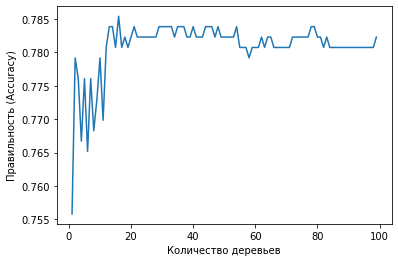

In [31]:
plt.plot(x,y)
plt.xlabel('Количество деревьев')
plt.ylabel('Правильность (Accuracy)')

Наилучшее количество идеальных деревьев для случайного леса - 5.

### Итоги

Расположим модели в порядке убывания правильности на валидационной выборке.

In [32]:
# функция для вывода результатов
def show_results(models, features, target, s):
    accuracy_d = {}
    for m in models:
        model = models[m]
        predictions = model.predict(features)
        accuracy = accuracy_score(target, predictions)
        accuracy_d[m] = accuracy

    # отсоримпрукем и выведем словарь
    sorted_dict = {}
    sorted_keys = sorted(accuracy_d, key=accuracy_d.get, reverse=True)  # [1, 3, 2]

    for w in sorted_keys:
        sorted_dict[w] = accuracy_d[w]

    print(s)
    n = 1            
    for i in sorted_dict:
        print(n, sorted_dict[i], i)
        n+=1

In [33]:
show_results(best_models, features_valid, target_valid, 'Результаты по валидационной выборке.')

Результаты по валидационной выборке.
1 0.8009331259720062 Модель № 9. Случайный лес - Широкий перебор
2 0.7931570762052877 Модель № 8. Случайный лес - узкий подбор
3 0.7900466562986003 Модель № 2. Дерево решений - Глубина дерева
4 0.7900466562986003 Модель № 4. Дерево решений - Максимум узлов
5 0.7900466562986003 Модель № 6. Случайный лес - Количество деревьев
6 0.7900466562986003 Модель № 7. Случайный лес - Количество деревьев и глубина 3
7 0.7884914463452566 Модель № 3. Дерево решений - Количество объектов на листьях
8 0.7869362363919129 Модель № 5. Идеальное дерево
9 0.7853810264385692 Модель № 10. Идеальный случайный лес
10 0.7076205287713841 Модель № 1. Логистическая регрессия


**Вывод.** Наилучшими моделями на валидационной выборке стали три модели случайного леса.

**1  Модель № 9. Случайный лес - Широкий перебор** 
- Правильность: 0.8009331259720062
- 0.8009331259720062 
- Количество деревьев: 5
- Максимальная глубина: 7

**2 Модель № 8. Случайный лес - узкий подбор**
- Правильность: 0.7900466562986003 
- Количество деревьев: 40

**3. Модель № 2. Дерево решений - Глубина дерева**
- Правильность: 0.7900466562986003 
- Максимальная глубина 5

## Проверка модели на тестовой выборке



In [34]:
show_results(best_models, features_test, target_test, 'Результаты по тестовой выборке.')

Результаты по тестовой выборке.
1 0.7978227060653188 Модель № 6. Случайный лес - Количество деревьев
2 0.7900466562986003 Модель № 9. Случайный лес - Широкий перебор
3 0.7884914463452566 Модель № 4. Дерево решений - Максимум узлов
4 0.7838258164852255 Модель № 2. Дерево решений - Глубина дерева
5 0.7822706065318819 Модель № 8. Случайный лес - узкий подбор
6 0.7744945567651633 Модель № 3. Дерево решений - Количество объектов на листьях
7 0.7744945567651633 Модель № 5. Идеальное дерево
8 0.7744945567651633 Модель № 7. Случайный лес - Количество деревьев и глубина 3
9 0.7682737169517885 Модель № 10. Идеальный случайный лес
10 0.6936236391912908 Модель № 1. Логистическая регрессия


**Вывод.** На тестовой выборке три наилучшие немного модели поменялись местами. На третьем и вовсе оказалась модель, прежде занимавшая 4-е место.

**1 Модель № 8. Случайный лес - Узкий подбор**
- Правильность: 0.7962674961119751
- Количество деревьев: 8 
- Максимальная глубина: 5

**2  Модель № 9. Случайный лес - Широкий перебор** 
- Правильность: 0.7962674961119751
- Количество деревьев: 40 
- Максимальная глубина: 8

**3.  Модель № 4. Дерево решений - Максимум узлов**
- Правильность: 0.7931570762052877
- Максимум узлов: 8

## Проверка модели на адекватность

Чтобы проверить модели на адекватность, мы должны сравнить их `accuracy` с `accuracy` случайной модели (`0.5`).

In [35]:
show_results(best_models, features_test, target_test, 'Результаты по тестовой выборке.')

Результаты по тестовой выборке.
1 0.7978227060653188 Модель № 6. Случайный лес - Количество деревьев
2 0.7900466562986003 Модель № 9. Случайный лес - Широкий перебор
3 0.7884914463452566 Модель № 4. Дерево решений - Максимум узлов
4 0.7838258164852255 Модель № 2. Дерево решений - Глубина дерева
5 0.7822706065318819 Модель № 8. Случайный лес - узкий подбор
6 0.7744945567651633 Модель № 3. Дерево решений - Количество объектов на листьях
7 0.7744945567651633 Модель № 5. Идеальное дерево
8 0.7744945567651633 Модель № 7. Случайный лес - Количество деревьев и глубина 3
9 0.7682737169517885 Модель № 10. Идеальный случайный лес
10 0.6936236391912908 Модель № 1. Логистическая регрессия


**Вывод.** Все `accuracy` больше 0.5, следовательно, все наши модели лучше случайной модели. Наихцдшмй результат, близкий к 0.5 показала *Модель № 1. Логистическая регрессия*.

Также мы проделвем две вещи:

- посчитаем дополнительные метрики на тестовой выборке;
- посчитаем правильность на всех данных вместе.

### Правильность, точность и полнота

Для проверки адекватности моделей, посчитаем помимо правильности (`accuracy`) ещё посчитаем точность (`precision`) и полноту (`recall`).

Метрики качества оценивают качество работы и выражаются в числовой форме. 

- Правильность  (англ. `accuracy`) показывает отношение числа правильных ответов к размеру выборки.   В некоторых переводах — «доля правильных ответов».
- Точность (англ. `precision`) показывает, какая доля объектов, отмеченных моделью как "Ultra", действительно относится к этому тарифу (ответ 1).
- Полнота (англ. `recall`) выявляет, какую часть объектов "Ultra" выделила модель.

In [36]:
def show_resulst_advanced(best_models, features, target):
    accuracy = []
    precision = []
    recall = []
    name = []
    for n in best_models:
        name.append(n)
        model = best_models[n]
        print('=============', n, '=============')
        predictions = model.predict(features)
        result = accuracy_score(target, predictions)
        accuracy.append(result)
        print('Accuracy на тестовой выборке: ', result)
        result = precision_score(target, predictions)
        precision.append(result)
        print('Precision на тестовой выборке: ', result)
        result = recall_score(target, predictions)
        recall.append(result)
        print('Recall на тестовой выборке: ', result)
    data = {'Name': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    table = pd.DataFrame(data)
    return table

print('Результаты на тестовых с дополнительными метриками')
table_test = show_resulst_advanced(best_models, features_test, target_test)
table_test

Результаты на тестовых с дополнительными метриками
============= Модель № 1. Логистическая регрессия =============
Accuracy на тестовой выборке:  0.6936236391912908
Precision на тестовой выборке:  0.7142857142857143
Recall на тестовой выборке:  0.04926108374384237
============= Модель № 2. Дерево решений - Глубина дерева =============
Accuracy на тестовой выборке:  0.7838258164852255
Precision на тестовой выборке:  0.7424242424242424
Recall на тестовой выборке:  0.4827586206896552
============= Модель № 3. Дерево решений - Количество объектов на листьях =============
Accuracy на тестовой выборке:  0.7744945567651633
Precision на тестовой выборке:  0.7013888888888888
Recall на тестовой выборке:  0.4975369458128079
============= Модель № 4. Дерево решений - Максимум узлов =============
Accuracy на тестовой выборке:  0.7884914463452566
Precision на тестовой выборке:  0.7342657342657343
Recall на тестовой выборке:  0.5172413793103449
============= Модель № 5. Идеальное дерево =============

,Name,Accuracy,Precision,Recall
0,Модель № 1. Логистическая регрессия,0.693624,0.714286,0.049261
1,Модель № 2. Дерево решений - Глубина дерева,0.783826,0.742424,0.482759
2,Модель № 3. Дерево решений - Количество объект...,0.774495,0.701389,0.497537
3,Модель № 4. Дерево решений - Максимум узлов,0.788491,0.734266,0.517241
4,Модель № 5. Идеальное дерево,0.774495,0.723077,0.463054
5,Модель № 6. Случайный лес - Количество деревьев,0.797823,0.713450,0.600985
6,Модель № 7. Случайный лес - Количество деревье...,0.774495,0.733871,0.448276
7,Модель № 8. Случайный лес - узкий подбор,0.782271,0.729927,0.492611
8,Модель № 9. Случайный лес - Широкий перебор,0.790047,0.757576,0.492611
9,Модель № 10. Идеальный случайный лес,0.768274,0.725000,0.428571


In [37]:
table_test.sort_values('Accuracy', ascending = False)

,Name,Accuracy,Precision,Recall
5,Модель № 6. Случайный лес - Количество деревьев,0.797823,0.713450,0.600985
8,Модель № 9. Случайный лес - Широкий перебор,0.790047,0.757576,0.492611
3,Модель № 4. Дерево решений - Максимум узлов,0.788491,0.734266,0.517241
1,Модель № 2. Дерево решений - Глубина дерева,0.783826,0.742424,0.482759
7,Модель № 8. Случайный лес - узкий подбор,0.782271,0.729927,0.492611
2,Модель № 3. Дерево решений - Количество объект...,0.774495,0.701389,0.497537
4,Модель № 5. Идеальное дерево,0.774495,0.723077,0.463054
6,Модель № 7. Случайный лес - Количество деревье...,0.774495,0.733871,0.448276
9,Модель № 10. Идеальный случайный лес,0.768274,0.725000,0.428571
0,Модель № 1. Логистическая регрессия,0.693624,0.714286,0.049261


In [38]:
table_test.sort_values('Precision', ascending = False)

,Name,Accuracy,Precision,Recall
8,Модель № 9. Случайный лес - Широкий перебор,0.790047,0.757576,0.492611
1,Модель № 2. Дерево решений - Глубина дерева,0.783826,0.742424,0.482759
3,Модель № 4. Дерево решений - Максимум узлов,0.788491,0.734266,0.517241
6,Модель № 7. Случайный лес - Количество деревье...,0.774495,0.733871,0.448276
7,Модель № 8. Случайный лес - узкий подбор,0.782271,0.729927,0.492611
9,Модель № 10. Идеальный случайный лес,0.768274,0.725000,0.428571
4,Модель № 5. Идеальное дерево,0.774495,0.723077,0.463054
0,Модель № 1. Логистическая регрессия,0.693624,0.714286,0.049261
5,Модель № 6. Случайный лес - Количество деревьев,0.797823,0.713450,0.600985
2,Модель № 3. Дерево решений - Количество объект...,0.774495,0.701389,0.497537


In [39]:
table_test.sort_values('Recall', ascending = False)

,Name,Accuracy,Precision,Recall
5,Модель № 6. Случайный лес - Количество деревьев,0.797823,0.713450,0.600985
3,Модель № 4. Дерево решений - Максимум узлов,0.788491,0.734266,0.517241
2,Модель № 3. Дерево решений - Количество объект...,0.774495,0.701389,0.497537
7,Модель № 8. Случайный лес - узкий подбор,0.782271,0.729927,0.492611
8,Модель № 9. Случайный лес - Широкий перебор,0.790047,0.757576,0.492611
1,Модель № 2. Дерево решений - Глубина дерева,0.783826,0.742424,0.482759
4,Модель № 5. Идеальное дерево,0.774495,0.723077,0.463054
6,Модель № 7. Случайный лес - Количество деревье...,0.774495,0.733871,0.448276
9,Модель № 10. Идеальный случайный лес,0.768274,0.725000,0.428571
0,Модель № 1. Логистическая регрессия,0.693624,0.714286,0.049261


**Итоги.**

**Правильность.**

1. *Модель № 6. Случайный лес - Количество деревьев* (`accuracy` = 0.797823)
2. *Модель № 9. Случайный лес - Широкий перебор* (`accuracy` = 0.790047)
3. *Модель № 4. Дерево решений - Максимум узлов* (`accuracy` = 0.788491)

**Точность.** Три наиболее правильных лидера оказались и наиболее точными:

1. *Модель № 9. Случайный лес - Широкий перебор* (`precision` = 0.757576).
2. *Модель № 2. Дерево решений - Глубина дерева* (`precision` = 0.742424).
3. *Модель № 4. Дерево решений - Максимум узлов* (`precision` = 0.734266).

**Полнота.** Две наиболее правильных лидера оказались и наиболее точными:

1. Модель № 6. Случайный лес - Количество деревьев* (`recall` = 0.600985).
2. Модель № 4. Дерево решений - Максимум узлов* (`recall` = 0.517241).
3. Модель № 3. Дерево решений - Количество объект..* (`recall` = 0.497537).

**Вывод.** Таким образом, наилучшие модели - это № 9, № 6, № 4 и № 3.

### По всем данным

Посмотрим, какие метрики будут на всей совокупности данных.

In [40]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [41]:
table = show_resulst_advanced(best_models, features, target)

============= Модель № 1. Логистическая регрессия =============
Accuracy на тестовой выборке:  0.7093963907902925
Precision на тестовой выборке:  0.8
Recall на тестовой выборке:  0.06903553299492386
============= Модель № 2. Дерево решений - Глубина дерева =============
Accuracy на тестовой выборке:  0.8042937149968886
Precision на тестовой выборке:  0.7825396825396825
Recall на тестовой выборке:  0.500507614213198
============= Модель № 3. Дерево решений - Количество объектов на листьях =============
Accuracy на тестовой выборке:  0.8018046048537648
Precision на тестовой выборке:  0.7485714285714286
Recall на тестовой выборке:  0.531979695431472
============= Модель № 4. Дерево решений - Максимум узлов =============
Accuracy на тестовой выборке:  0.806471686372122
Precision на тестовой выборке:  0.7680945347119645
Recall на тестовой выборке:  0.5279187817258884
============= Модель № 5. Идеальное дерево =============
Accuracy на тестовой выборке:  0.7958929682638457
Precision на тесто

In [42]:
table.sort_values('Accuracy', ascending = False)

,Name,Accuracy,Precision,Recall
5,Модель № 6. Случайный лес - Количество деревьев,0.915993,0.901235,0.815228
8,Модель № 9. Случайный лес - Широкий перебор,0.822962,0.833333,0.527919
7,Модель № 8. Случайный лес - узкий подбор,0.811450,0.804173,0.508629
3,Модель № 4. Дерево решений - Максимум узлов,0.806472,0.768095,0.527919
1,Модель № 2. Дерево решений - Глубина дерева,0.804294,0.782540,0.500508
2,Модель № 3. Дерево решений - Количество объект...,0.801805,0.748571,0.531980
6,Модель № 7. Случайный лес - Количество деревье...,0.797138,0.787565,0.462944
9,Модель № 10. Идеальный случайный лес,0.796204,0.784483,0.461929
4,Модель № 5. Идеальное дерево,0.795893,0.762360,0.485279
0,Модель № 1. Логистическая регрессия,0.709396,0.800000,0.069036


In [43]:
table.sort_values('Precision', ascending = False)

,Name,Accuracy,Precision,Recall
5,Модель № 6. Случайный лес - Количество деревьев,0.915993,0.901235,0.815228
8,Модель № 9. Случайный лес - Широкий перебор,0.822962,0.833333,0.527919
7,Модель № 8. Случайный лес - узкий подбор,0.811450,0.804173,0.508629
0,Модель № 1. Логистическая регрессия,0.709396,0.800000,0.069036
6,Модель № 7. Случайный лес - Количество деревье...,0.797138,0.787565,0.462944
9,Модель № 10. Идеальный случайный лес,0.796204,0.784483,0.461929
1,Модель № 2. Дерево решений - Глубина дерева,0.804294,0.782540,0.500508
3,Модель № 4. Дерево решений - Максимум узлов,0.806472,0.768095,0.527919
4,Модель № 5. Идеальное дерево,0.795893,0.762360,0.485279
2,Модель № 3. Дерево решений - Количество объект...,0.801805,0.748571,0.531980


In [44]:
table.sort_values('Recall', ascending = False)

,Name,Accuracy,Precision,Recall
5,Модель № 6. Случайный лес - Количество деревьев,0.915993,0.901235,0.815228
2,Модель № 3. Дерево решений - Количество объект...,0.801805,0.748571,0.531980
3,Модель № 4. Дерево решений - Максимум узлов,0.806472,0.768095,0.527919
8,Модель № 9. Случайный лес - Широкий перебор,0.822962,0.833333,0.527919
7,Модель № 8. Случайный лес - узкий подбор,0.811450,0.804173,0.508629
1,Модель № 2. Дерево решений - Глубина дерева,0.804294,0.782540,0.500508
4,Модель № 5. Идеальное дерево,0.795893,0.762360,0.485279
6,Модель № 7. Случайный лес - Количество деревье...,0.797138,0.787565,0.462944
9,Модель № 10. Идеальный случайный лес,0.796204,0.784483,0.461929
0,Модель № 1. Логистическая регрессия,0.709396,0.800000,0.069036


**Итоги.**

**Правильность.** Три наиболее правильных лидера оказались и наиболее точными:

1. *Модель № 6. Случайный лес - Количество деревьев* (`accuracy` = 00.915993).
2. *Модель № 9. Случайный лес - Широкий перебор* (`accuracy` = 00.822962).
3. *Модель № 8. Случайный лес - узкий подбор* (`accuracy` = 00.811450).

**Точность.** Три наиболее правильных лидера оказались и наиболее точными:

1. *Модель № 6. Случайный лес - Количество деревьев*  (`precision` = 0.901235).
2. *Модель № 9. Случайный лес - Широкий перебор*  (`precision` = 0.833333).
3. *Модель № 8. Случайный лес - узкий подбор*  (`precision` = 0.804173).

**Полнота.** Две наиболее правильных лидера оказались и наиболее точными:

1. *ММодель № 6. Случайный лес - Количество деревьев* (`recall` = 0.810152).
2. *Модель № 9. Случайный лес - Широкий перебор* (`recall` = 0.568528).
3. *Модель № 3. Дерево решений - Количество объектов на листьях* (`recall` = 0.522843).

**Вывод.**. Неудивительно, но мало что поменялось. Таким образом, наилучшие модели - это № 6, № 9, № 8 и № 3.

**Общий Вывод.** Таким образом, наилучшие модели - это № 4, № 6, № 8 и № 9. Их метрики наилучшие.